In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from IPython.display import HTML, Video
from moviepy.editor import VideoFileClip
from LaneLines import *

In [2]:
cap = cv2.VideoCapture("new_road3.mp4")

In [7]:
while cap.isOpened():
    ret, frame = cap.read()
    break

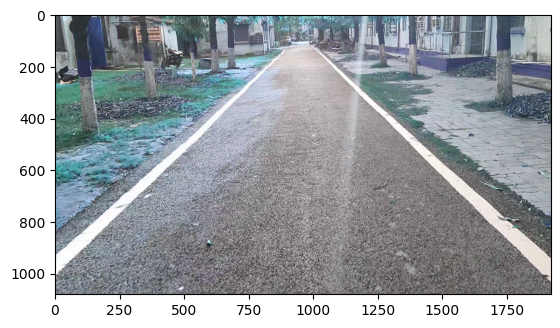

In [50]:
frame = cv2.imread("new_road_frames/new_road_1400.jpg")
plt.imshow(frame)

In [51]:
frame.shape

(1080, 1920, 3)

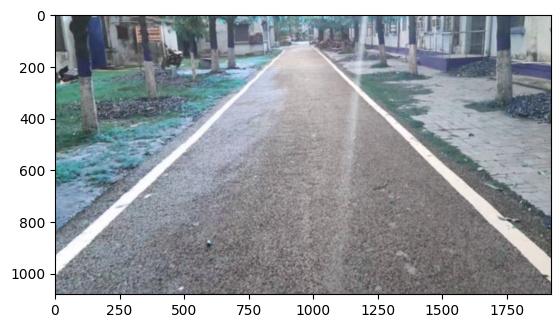

In [52]:
# lane_image = mpimg.imread('lane_junior_frames/lane_juniors_frame110.jpg')
# print(lane_image.shape)
img = np.copy(frame)
img = cv2.GaussianBlur(img, (11,11), 0)
plt.imshow(img)

In [53]:
def threshold_rel(img, lo, hi):
    vmin = np.min(img)
    vmax = np.max(img)
    
    vlo = vmin + (vmax - vmin) * lo
    vhi = vmin + (vmax - vmin) * hi
    return np.uint8((img >= vlo) & (img <= vhi)) * 255

def threshold_abs(img, lo, hi):
    return np.uint8((img >= lo) & (img <= hi)) * 255

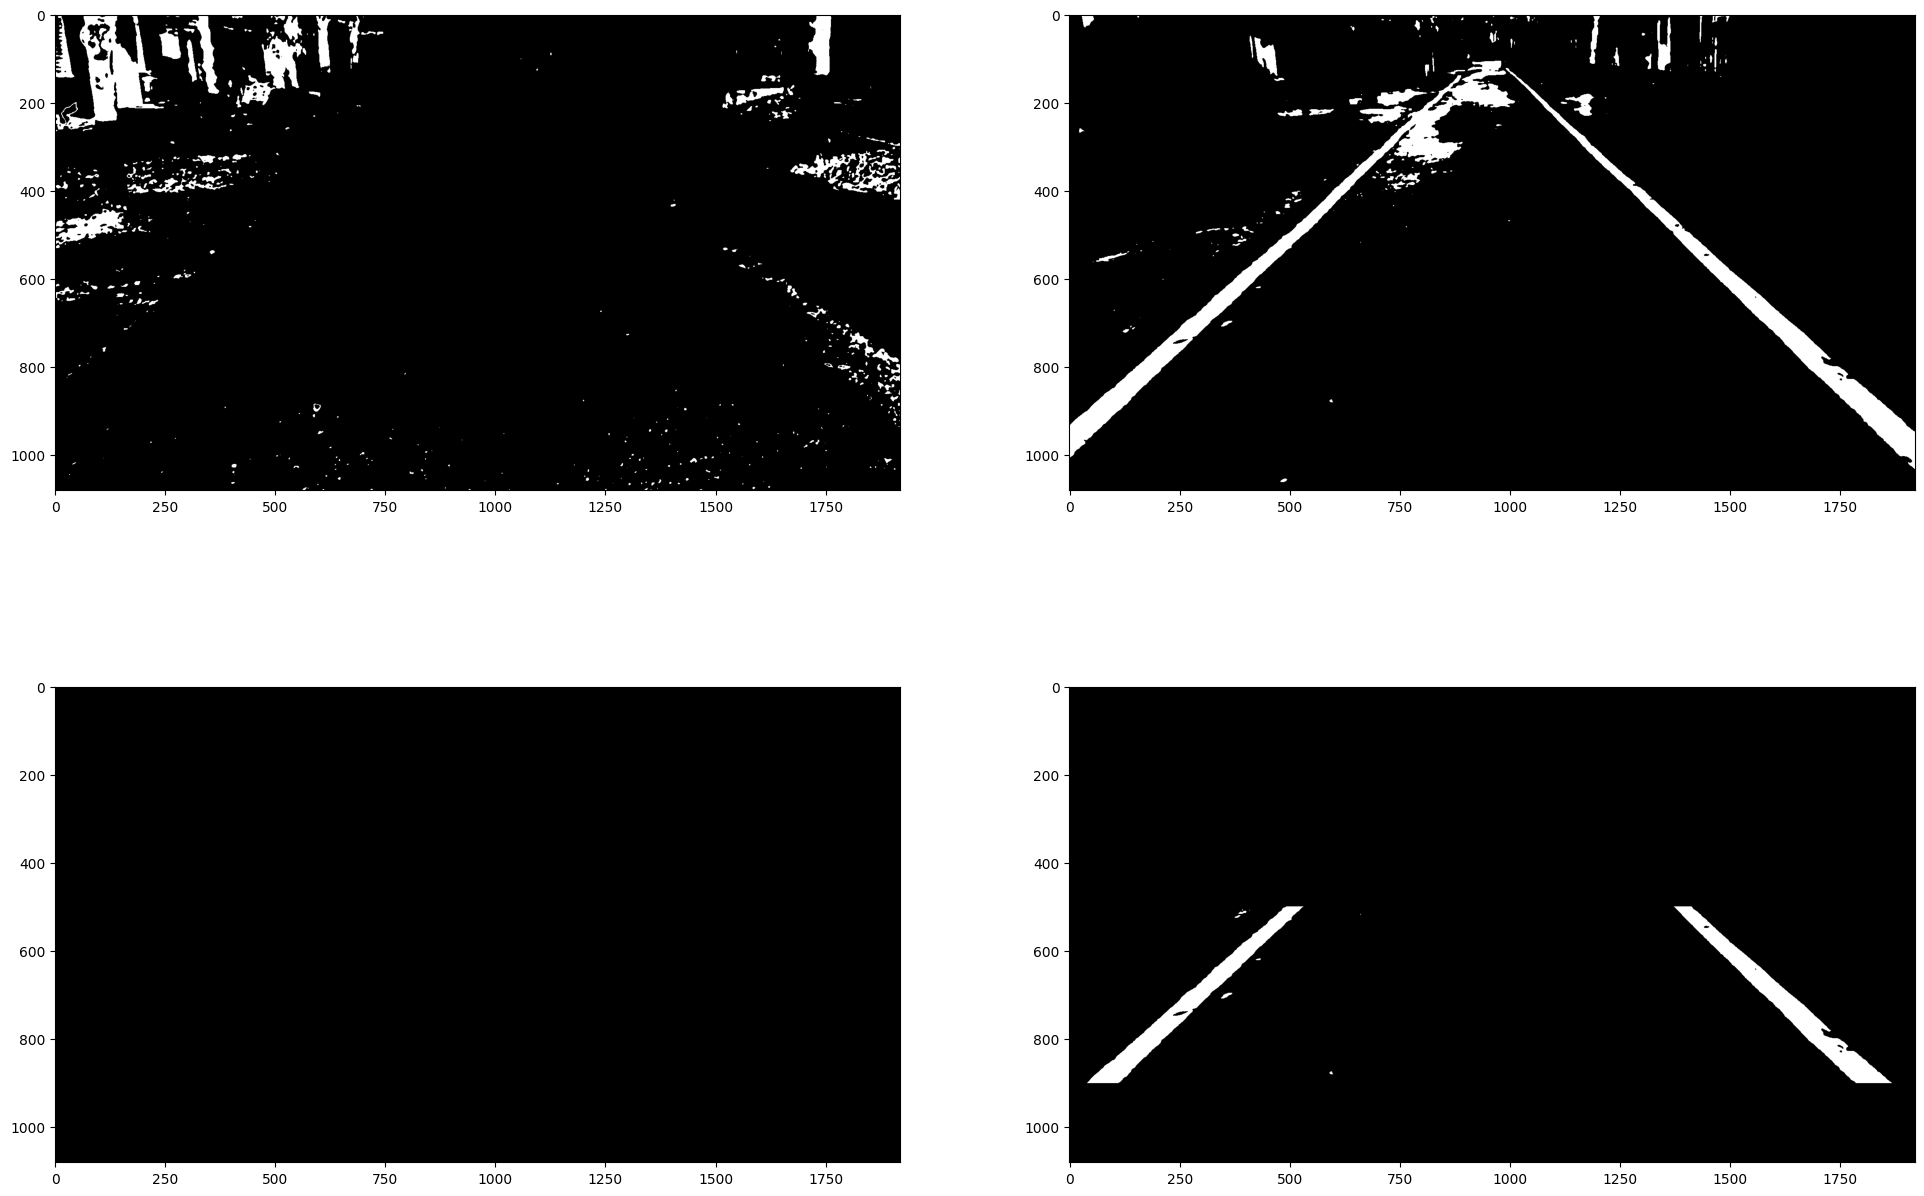

In [54]:
def test(img):
#     tmp = birdeye.forward(img)
    tmp = np.copy(img)
    hls = cv2.cvtColor(tmp, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(tmp, cv2.COLOR_RGB2HSV)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    v_channel = hsv[:,:,2]
    
#     f = plt.figure(figsize=(24, 16))
#     ax1 = f.add_subplot(2, 2, 1)
#     ax1.imshow(tmp)
#     ax2 = f.add_subplot(2, 2, 2)
#     right_lane = threshold_rel(l_channel, 0.3, 0.9)
#     right_lane[:,:2125]=0
    
# #     ax4.imshow(right_lane, vmin=0, vmax=255, cmap='gray')
    
#     ax3 = f.add_subplot(2, 2, 3)
# #     ax1.imshow(threshold_rel(s_channel, 0.09, 0.3), vmin=0, vmax=255, cmap='gray')
# #     ax2.imshow(threshold_rel(s_channel, 0.1, 0.3), vmin=0, vmax=255, cmap='gray')
# #     ax3.imshow(threshold_rel(s_channel, 0.1, 0.23), vmin=0, vmax=255, cmap='gray')
#     ax4 = f.add_subplot(2, 2, 4)
    
#     res1 = threshold_abs(h_channel, 10, 85)
#     res2 = threshold_rel(v_channel, 0.68, 1.0)
#     lanes = res1 & res2
    
    
    
    f = plt.figure(figsize=(24, 16))
    ax1 = f.add_subplot(2, 2, 1)
    ax1.imshow(threshold_abs(l_channel, 50, 80), vmin=0, vmax=255, cmap='gray')
    ax2 = f.add_subplot(2, 2, 2)
    ax2.imshow(threshold_rel(v_channel, 0.83, 1.0), vmin=0, vmax=255, cmap='gray')
    # ax1.imshow(tmp)
    res1 = threshold_abs(l_channel, 50, 80)
    res2 = threshold_rel(v_channel, 0.83, 1.0)
    lanes = res1 & res2
    ax3 = f.add_subplot(2, 2, 3)
    ax3.imshow(lanes, vmin=0, vmax=255, cmap='gray')
    # ax2.imshow(h_channel, vmin=0, vmax=255, cmap='gray')
    
    height, width = img.shape[0], img.shape[1]
    region_of_interest = np.array([
        [(400, 500), (0, 900), (width, 900), (1600, 500)]
        ])
    mask = np.zeros_like(lanes)
    cv2.fillConvexPoly(mask, region_of_interest, 255)
    # ax3.imshow(mask, vmin=0, vmax=255, cmap='gray')
    # ax3.imshow(v_channel, vmin=0, vmax=255, cmap='gray')
#     print(lanes.shape)
#     print(mask.shape)
    lane_lines = res2 & mask
    lane_lines[:700,1300] = 0
       
    ax4 = f.add_subplot(2, 2, 4)
    ax4.imshow(lane_lines, vmin=0, vmax=255, cmap='gray')
    # ax4.imshow(s_channel, vmin=0, vmax=255, cmap='gray')

test(img)
    

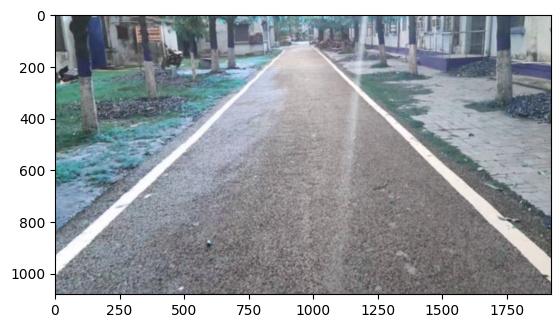

In [55]:
plt.imshow(img)

In [64]:
class PerspectiveTransformation:
    """ This a class for transforming image between front view and top view

    Attributes:
        src (np.array): Coordinates of 4 source points
        dst (np.array): Coordinates of 4 destination points
        M (np.array): Matrix to transform image from front view to top view
        M_inv (np.array): Matrix to transform image from top view to front view
    """
    def __init__(self):
        """Init PerspectiveTransformation."""
        # self.src = np.float32([(550, 460),     # top-left
        #                        (150, 720),     # bottom-left
        #                        (1200, 720),    # bottom-right
        #                        (770, 460)])    # top-right
        # self.dst = np.float32([(100, 0),
        #                        (100, 720),
        #                        (1100, 720),
        #                        (1100, 0)])

        # self.src = np.float32([(500, 250),     # top-left
        #                        (0, 600),     # bottom-left
        #                        (1600, 600),    # bottom-right
        #                        (1300, 250)])    # top-right


        height, width = img.shape[0], img.shape[1]

        region_of_interest = np.array([
        [(400, 500), (0, 900), (width, 900), (1600, 500)]
        ])
        
        self.src = np.float32([(400, 500), 
                               (0, 900), 
                               (width, 900), 
                               (1600, 500)])
        self.dst = np.float32([(100, 0),
                               (100, height),
                               (width-100, height),
                               (width-100, 0)])

        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.M_inv = cv2.getPerspectiveTransform(self.dst, self.src)

    def forward(self, img, img_size=(1920, 1080), flags=cv2.INTER_LINEAR):
        """ Take a front view image and transform to top view

        Parameters:
            img (np.array): A front view image
            img_size (tuple): Size of the image (width, height)
            flags : flag to use in cv2.warpPerspective()

        Returns:
            Image (np.array): Top view image
        """
        return cv2.warpPerspective(img, self.M, img_size, flags=flags)

    def backward(self, img, img_size=(1920, 1080), flags=cv2.INTER_LINEAR):
        """ Take a top view image and transform it to front view

        Parameters:
            img (np.array): A top view image
            img_size (tuple): Size of the image (width, height)
            flags (int): flag to use in cv2.warpPerspective()

        Returns:
            Image (np.array): Front view image
        """
        return cv2.warpPerspective(img, self.M_inv, img_size, flags=flags)

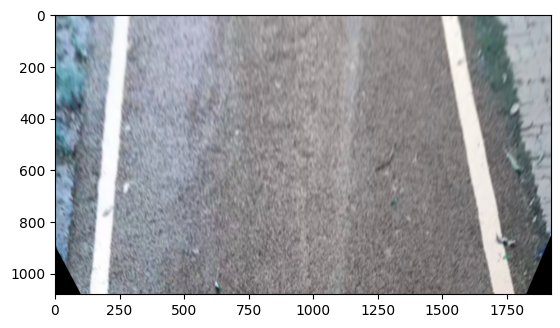

In [65]:
birdeye = PerspectiveTransformation()
img1 = birdeye.forward(img)
plt.imshow(img1)

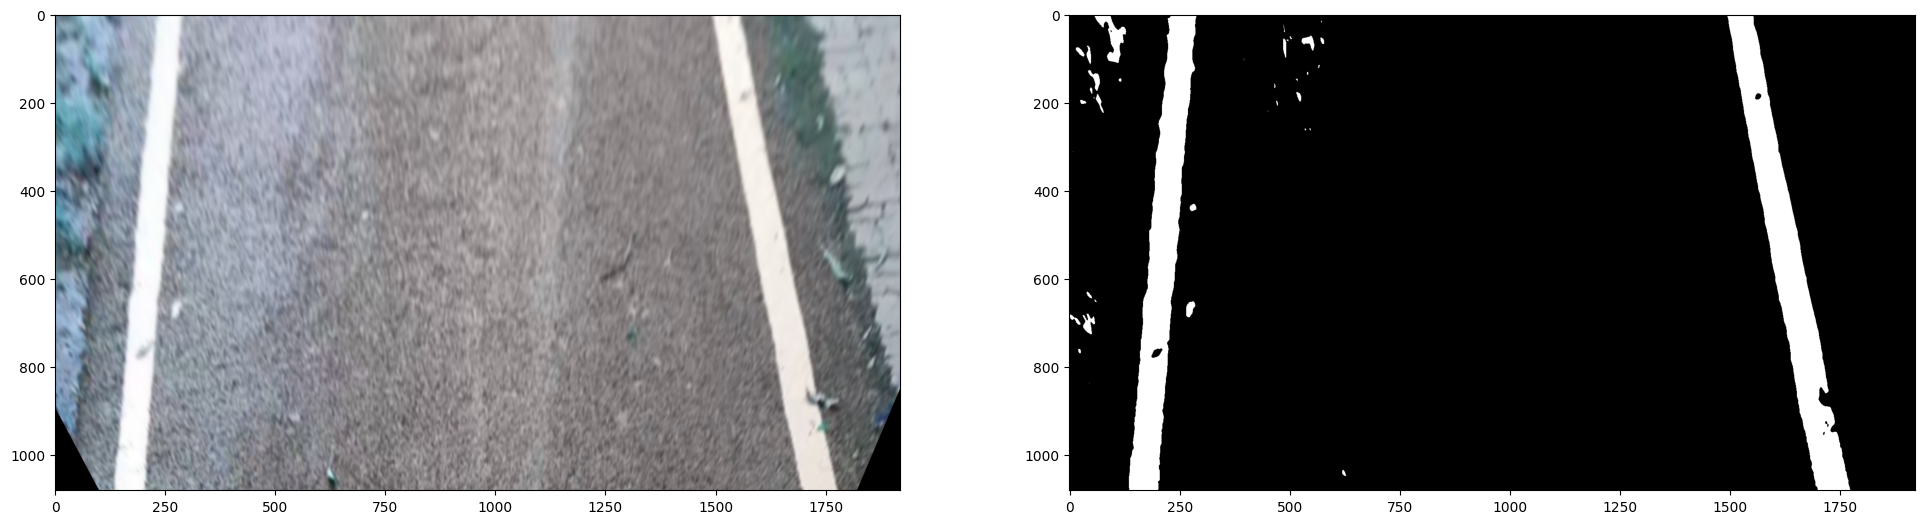

In [66]:
hls = cv2.cvtColor(img1, cv2.COLOR_RGB2HLS)
hsv = cv2.cvtColor(img1, cv2.COLOR_RGB2HSV)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]
v_channel = hsv[:,:,2]


f = plt.figure(figsize=(24, 16))
ax1 = f.add_subplot(1, 2, 1)
ax1.imshow(img1)
ax2 = f.add_subplot(1, 2, 2)
lanes = threshold_rel(v_channel, 0.83, 1.0)
lanes[:,700:1300]=0
ax2.imshow(lanes, vmin=0, vmax=255, cmap='gray')


# ax3 = f.add_subplot(3, 2, 3)
# ax3.imshow(threshold_rel(s_channel, 0.1, 0.23), vmin=0, vmax=255, cmap='gray')
 
# ax4 = f.add_subplot(3, 2, 4)
# ax5 = f.add_subplot(3, 2, 5)
# ax6 = f.add_subplot(3, 2, 6)
# res1 = threshold_abs(h_channel, 10, 90)
# ax4.imshow(threshold_rel(s_channel, 0.1, 0.23) & right_lane, vmin=0, vmax=255, cmap='gray')
# res2 = threshold_rel(v_channel, 0.68, 1.0)
# ax5.imshow(res2, vmin=0, vmax=255, cmap='gray')
# img2 = res1 & res2
# ax6.imshow(img2, vmin=0, vmax=255, cmap='gray')

In [67]:
lanelines = LaneLines()
img3 = lanelines.forward(lanes)
plt.imshow(img3)

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [15]:
img4 = birdeye.backward(img3)
out_img = cv2.addWeighted(img, 1, img4, 0.3, 0)
cv2.namedWindow("out_img", cv2.WINDOW_NORMAL)  

W = 1300
H = 201
widget = np.copy(out_img[:H, :W])
widget //= 2
widget[0,:] = [0, 0, 255]
widget[-1,:] = [0, 0, 255]
widget[:,0] = [0, 0, 255]
widget[:,-1] = [0, 0, 255]
out_img[:H, :W] = widget
        
cv2.putText(
            out_img,
            "Vehicle is 1.00m away from center",
            org=(50, 110),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=2,
            color=(255, 255, 255),
            thickness=5)
cv2.imshow('out_img', out_img)
cv2.waitKey(0)

-1

In [17]:
birdeye = PerspectiveTransformation()
lanelines = LaneLines()
def process_image(img):
    # step 1
    img1 = cv2.GaussianBlur(img, (11,11), 0)
    img1 = birdeye.forward(img1)
#     img1 = np.copy(img)
    
    # step 2
    hls = cv2.cvtColor(img1, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img1, cv2.COLOR_RGB2HSV)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    v_channel = hsv[:,:,2]
    
    lanes = threshold_rel(v_channel, 0.9, 1.0)
    
    height = img.shape[0]
    # region_of_interest = np.array([
    #     [(1150, 1450), (250, height), (3300, height), (2350, 1450)]
    #     ])
    # mask = np.zeros_like(lanes)
    # cv2.fillConvexPoly(mask, region_of_interest, 255)
    
    img2 = np.copy(lanes)
    

#     right_lane = threshold_rel(l_channel, 0.8, 1.0)
#     right_lane[:,:750] = 0

#     left_lane = threshold_abs(h_channel, 10, 80)
#     left_lane &= threshold_rel(v_channel, 0.68, 1.0)
#     left_lane[:,550:] = 0

#     img2 = left_lane | right_lane
    
#     img2 = birdeye.forward(img2)
    
    # step 3
    img3 = lanelines.forward(img2)
    
    # step 4
    img4 = birdeye.backward(img3)
    out_img = cv2.addWeighted(img, 1, img4, 1, 0)
    
    return out_img

In [31]:
cap = cv2.VideoCapture("new_road3.mp4")

while cap.isOpened():
    ret, frame = cap.read()
    out = process_image(frame)
    cv2.imshow("processed", out)
    # cv2.waitKey(2)
    if cv2.waitKey(10) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [29]:
cap.release()
cv2.destroyAllWindows()

In [18]:
clip = VideoFileClip("new_road.mp4")

In [20]:
out_clip = clip.fl_image(process_image)
out_clip.write_videofile("output_lane_juniors.mp4", audio=False)

Moviepy - Building video output_lane_juniors.mp4.
Moviepy - Writing video output_lane_juniors.mp4



Moviepy - Done !
Moviepy - video ready output_lane_juniors.mp4


In [ ]:
Video("output_lane_juniors.mp4", width = 848, height=480)

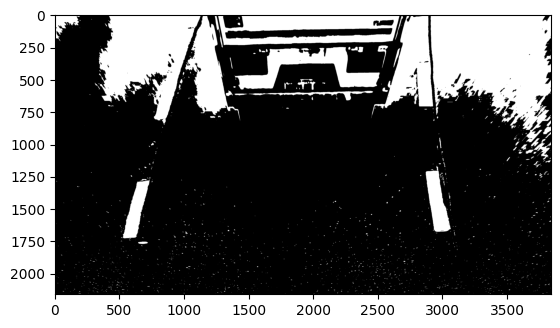

In [36]:
plt.imshow(img2, cmap='gray')

In [34]:
def hist(img):
    bottom_half = img[img.shape[0]//2:,:]
#     plt.imshow(bottom_half, cmap='gray')
    return np.sum(bottom_half, axis=0)

In [35]:
histogram = hist(right_lane)
print(histogram.shape)
midpoint = histogram.shape[0]//2
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

(3840,)


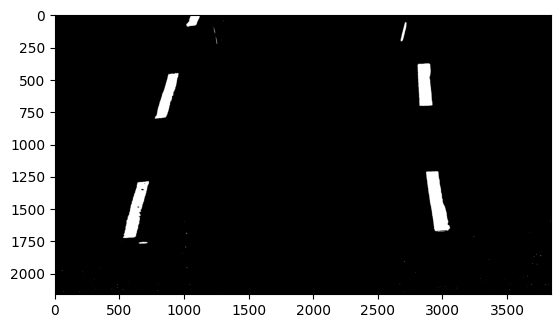

In [39]:
plt.imshow(right_lane, cmap='gray')

In [40]:
out_img = np.dstack((right_lane, right_lane, right_lane))
out_img

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

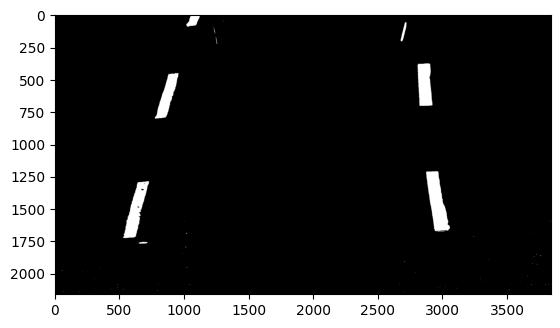

In [42]:
plt.imshow(out_img)

In [65]:
import cv2
import numpy as np
import matplotlib.image as mpimg

def hist(img):
    bottom_half = img[img.shape[0]//2:,:]
    return np.sum(bottom_half, axis=0)

class LaneLines:
    """ Class containing information about detected lane lines.

    Attributes:
        left_fit (np.array): Coefficients of a polynomial that fit left lane line
        right_fit (np.array): Coefficients of a polynomial that fit right lane line
        parameters (dict): Dictionary containing all parameters needed for the pipeline
        debug (boolean): Flag for debug/normal mode
    """
    def __init__(self):
        """Init Lanelines.

        Parameters:
            left_fit (np.array): Coefficients of polynomial that fit left lane
            right_fit (np.array): Coefficients of polynomial that fit right lane
            binary (np.array): binary image
        """
        self.leftx_base = None
        self.rightx_base = None
        self.left_fit = None
        self.right_fit = None
        self.binary = None
        self.nonzero = None
        self.nonzerox = None
        self.nonzeroy = None
        self.clear_visibility = True
        self.dir = []
        self.left_curve_img = mpimg.imread('left_turn.png')
        self.right_curve_img = mpimg.imread('right_turn.png')
        self.keep_straight_img = mpimg.imread('straight.png')
        self.left_curve_img = cv2.normalize(src=self.left_curve_img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        self.right_curve_img = cv2.normalize(src=self.right_curve_img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        self.keep_straight_img = cv2.normalize(src=self.keep_straight_img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

        # HYPERPARAMETERS
        # Number of sliding windows
        self.nwindows = 9
        # Width of the the windows +/- margin
        self.margin = 300
        # Mininum number of pixels found to recenter window
        self.minpix = 450

    def forward(self, img):
        """Take a image and detect lane lines.

        Parameters:
            img (np.array): An binary image containing relevant pixels

        Returns:
            Image (np.array): An RGB image containing lane lines pixels and other details
        """
        self.extract_features(img)
        return self.fit_poly(img)

    def pixels_in_window(self, center, margin, height):
        """ Return all pixel that in a specific window

        ->  Now that we have set the left and right base, we slide our windows vertically 
            upward from the base points n times where n = self.nwindows and check for white 
            pixels in each window. The height of each window is img.shape[0]//self.nwindows 
            and the width is (self.margin)*2. We append leftx, lefty, rightx, righty appropriately. 
            If the number of white pixels in that window is more than self.minpix, then we 
            shift the center of the window to the mean of x coordinates of those white pixels.

        Parameters:
            center (tuple): coordinate of the center of the window
            margin (int): half width of the window
            height (int): height of the window

        Returns:
            pixelx (np.array): x coordinates of white pixels that lie inside the window
            pixely (np.array): y coordinates of white pixels that lie inside the window
        """
        topleft = (center[0]-margin, center[1]-height//2)
        bottomright = (center[0]+margin, center[1]+height//2)

        condx = (topleft[0] <= self.nonzerox) & (self.nonzerox <= bottomright[0])
        condy = (topleft[1] <= self.nonzeroy) & (self.nonzeroy <= bottomright[1])
        return self.nonzerox[condx&condy], self.nonzeroy[condx&condy]

    def extract_features(self, img):
        """ Extract features from a binary image

        Parameters:
            img (np.array): A binary image
        """
        self.img = img
        # Height of of windows - based on nwindows and image shape
        self.window_height = np.int(img.shape[0]//self.nwindows)

        # Identify the x and y positions of all nonzero pixel in the image
        self.nonzero = img.nonzero()
        self.nonzerox = np.array(self.nonzero[1])
        self.nonzeroy = np.array(self.nonzero[0])

    def find_lane_pixels(self, img):
        """Find lane pixels from a binary warped image.

        Parameters:
            img (np.array): A binary warped image

        Returns:
            leftx (np.array): x coordinates of left lane pixels
            lefty (np.array): y coordinates of left lane pixels
            rightx (np.array): x coordinates of right lane pixels
            righty (np.array): y coordinates of right lane pixels
            out_img (np.array): A RGB image that use to display result later on.
        """
        assert(len(img.shape) == 2)

        # Create an output image to draw on and visualize the result
        out_img = np.dstack((img, img, img))

        # Checks vertically (axis0) for max amount of white pixels and sets that as base
        histogram = hist(img)
        midpoint = histogram.shape[0]//2
        self.leftx_base = np.argmax(histogram[:midpoint])
        self.rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Current position to be update later for each window in nwindows
        leftx_current = self.leftx_base
        rightx_current = self.rightx_base
        y_current = img.shape[0] + self.window_height//2

        # Create empty lists to recieve left and right lane pixel
        leftx, lefty, rightx, righty = [], [], [], []

        # Step through the windows one by one
        for _ in range(self.nwindows):
            y_current -= self.window_height
            center_left = (leftx_current, y_current)
            center_right = (rightx_current, y_current)

            good_left_x, good_left_y = self.pixels_in_window(center_left, self.margin, self.window_height)
            good_right_x, good_right_y = self.pixels_in_window(center_right, self.margin, self.window_height)

            # Append these indices to the lists
            leftx.extend(good_left_x)
            lefty.extend(good_left_y)
            rightx.extend(good_right_x)
            righty.extend(good_right_y)

            if len(good_left_x) > self.minpix:
                leftx_current = np.int32(np.mean(good_left_x))
            if len(good_right_x) > self.minpix:
                rightx_current = np.int32(np.mean(good_right_x))

        return leftx, lefty, rightx, righty, out_img

    def fit_poly(self, img):
        """Find the lane line from an image and draw it.

        Parameters:
            img (np.array): a binary warped image

        Returns:
            out_img (np.array): a RGB image that have lane line drawn on that.
        """

        leftx, lefty, rightx, righty, out_img = self.find_lane_pixels(img)

        if len(lefty) > 1500:
            self.left_fit = np.polyfit(lefty, leftx, 2)
        if len(righty) > 1500:
            self.right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        maxy = img.shape[0] - 1
        miny = img.shape[0] // 3
        if len(lefty):
            maxy = max(maxy, np.max(lefty))
            miny = min(miny, np.min(lefty))

        if len(righty):
            maxy = max(maxy, np.max(righty))
            miny = min(miny, np.min(righty))

        ploty = np.linspace(miny, maxy, img.shape[0])


        # x' = a*y^2 + b*y + c
        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

        # Visualization
        for i, y in enumerate(ploty):
            l = int(left_fitx[i])
            r = int(right_fitx[i])
            y = int(y)
            cv2.line(out_img, (l, y), (r, y), (0, 255, 0))

        # lR, rR, pos = self.measure_curvature()

        return out_img

    def plot(self, out_img):
        np.set_printoptions(precision=6, suppress=True)
        # lR, rR, pos = self.measure_curvature()
        pos = self.measure_curvature()

        # value = None
        # if abs(self.left_fit[0]) > abs(self.right_fit[0]):
        #     value = self.left_fit[0]
        # else:
        #     value = self.right_fit[0]

        # if abs(value) <= 0.00015:
        #     self.dir.append('F')
        # elif value < 0:
        #     self.dir.append('L')
        # else:
        #     self.dir.append('R')
        
        # if len(self.dir) > 10:
        #     self.dir.pop(0)

        # W = 400
        # H = 500
        # widget = np.copy(out_img[:H, :W])
        # widget //= 2
        # widget[0,:] = [0, 0, 255]
        # widget[-1,:] = [0, 0, 255]
        # widget[:,0] = [0, 0, 255]
        # widget[:,-1] = [0, 0, 255]
        # out_img[:H, :W] = widget

        # direction = max(set(self.dir), key = self.dir.count)
        # msg = "Keep Straight Ahead"
        # # curvature_msg = "Curvature = {:.0f} m".format(min(lR, rR))
        # if direction == 'L':
        #     y, x = self.left_curve_img[:,:,3].nonzero()
        #     out_img[y, x-100+W//2] = self.left_curve_img[y, x, :3]
        #     msg = "Left Curve Ahead"
        # if direction == 'R':
        #     y, x = self.right_curve_img[:,:,3].nonzero()
        #     out_img[y, x-100+W//2] = self.right_curve_img[y, x, :3]
        #     msg = "Right Curve Ahead"
        # if direction == 'F':
        #     y, x = self.keep_straight_img[:,:,3].nonzero()
        #     out_img[y, x-100+W//2] = self.keep_straight_img[y, x, :3]

        # cv2.putText(out_img, msg, org=(10, 240), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)
        # if direction in 'LR':
        #     cv2.putText(out_img, curvature_msg, org=(10, 280), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

        # cv2.putText(
        #     out_img,
        #     "Good Lane Keeping",
        #     org=(10, 400),
        #     fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        #     fontScale=1.2,
        #     color=(0, 255, 0),
        #     thickness=2)

        W = 1300
        H = 201
        widget = np.copy(out_img[:H, :W])
        widget //= 2
        widget[0,:] = [0, 0, 255]
        widget[-1,:] = [0, 0, 255]
        widget[:,0] = [0, 0, 255]
        widget[:,-1] = [0, 0, 255]
        out_img[:H, :W] = widget
        
        cv2.putText(
            out_img,
            "Vehicle is 1.00m away from center",
            org=(50, 110),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=2,
            color=(255, 255, 255),
            thickness=5)

        return out_img

    def measure_curvature(self):
        # ym = 30/720
        # xm = 3.7/700

        # left_fit = self.left_fit.copy()
        # right_fit = self.right_fit.copy()
        # y_eval = 700 * ym

        # Compute R_curve (radius of curvature)
        # left_curveR =  ((1 + (2*left_fit[0] *y_eval + left_fit[1])**2)**1.5)  / np.absolute(2*left_fit[0])
        # right_curveR = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

        # xl = np.dot(self.left_fit, [700**2, 700, 1])
        # xr = np.dot(self.right_fit, [700**2, 700, 1])
        # pos = (1280//2 - (xl+xr)//2)*xm
        # return left_curveR, right_curveR, pos

        xm = 2/(self.rightx_base - self.leftx_base)

        xl = np.copy(self.leftx_base)
        xr = np.copy(self.rightx_base)
        pos = (3840//2 - (xl+xr)//2)*xm
        return pos


In [67]:
def threshold(img1):
    hls = cv2.cvtColor(img1, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img1, cv2.COLOR_RGB2HSV)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    v_channel = hsv[:,:,2]


    f = plt.figure(figsize=(24, 16))
    ax1 = f.add_subplot(3, 2, 1)
    ax1.imshow(img1)
    ax2 = f.add_subplot(3, 2, 2)
    right_lane = threshold_rel(l_channel, 0.8, 1.0)
    right_lane[:,1300:2600]=0
    return right_lane

In [68]:
def birdeye(frame):
    birdeye = PerspectiveTransformation()
    img1 = birdeye.forward(frame)
    return img1

In [102]:
images = []
# images.append(mpimg.imread('lane_junior_frames/lane_juniors_frame0.jpg'))
# images.append(mpimg.imread('lane_junior_frames/lane_juniors_frame10.jpg'))
# images.append(mpimg.imread('lane_junior_frames/lane_juniors_frame20.jpg'))
# images.append(mpimg.imread('lane_junior_frames/lane_juniors_frame30.jpg'))
# images.append(mpimg.imread('lane_junior_frames/lane_juniors_frame40.jpg'))
# images.append(mpimg.imread('lane_junior_frames/lane_juniors_frame50.jpg'))
# images.append(mpimg.imread('lane_junior_frames/lane_juniors_frame60.jpg'))
# images.append(mpimg.imread('lane_junior_frames/lane_juniors_frame70.jpg'))
# images.append(mpimg.imread('lane_junior_frames/lane_juniors_frame80.jpg'))
# images.append(mpimg.imread('lane_junior_frames/lane_juniors_frame90.jpg'))
# images.append(mpimg.imread('lane_junior_frames/lane_juniors_frame100.jpg'))
images.append(mpimg.imread('lane_junior_frames/lane_juniors_frame110.jpg'))
# images.append(mpimg.imread('lane_junior_frames/lane_juniors_frame120.jpg'))
# images.append(mpimg.imread('lane_junior_frames/lane_juniors_frame130.jpg'))
# images.append(mpimg.imread('lane_junior_frames/lane_juniors_frame140.jpg'))
# images.append(mpimg.imread('lane_junior_frames/lane_juniors_frame150.jpg'))
# images.append(mpimg.imread('lane_junior_frames/lane_juniors_frame160.jpg'))
# images.append(mpimg.imread('lane_junior_frames/lane_juniors_frame170.jpg'))
# images.append(mpimg.imread('lane_junior_frames/lane_juniors_frame180.jpg'))
# images.append(mpimg.imread('lane_junior_frames/lane_juniors_frame190.jpg'))
# images.append(mpimg.imread('lane_junior_frames/lane_juniors_frame200.jpg'))


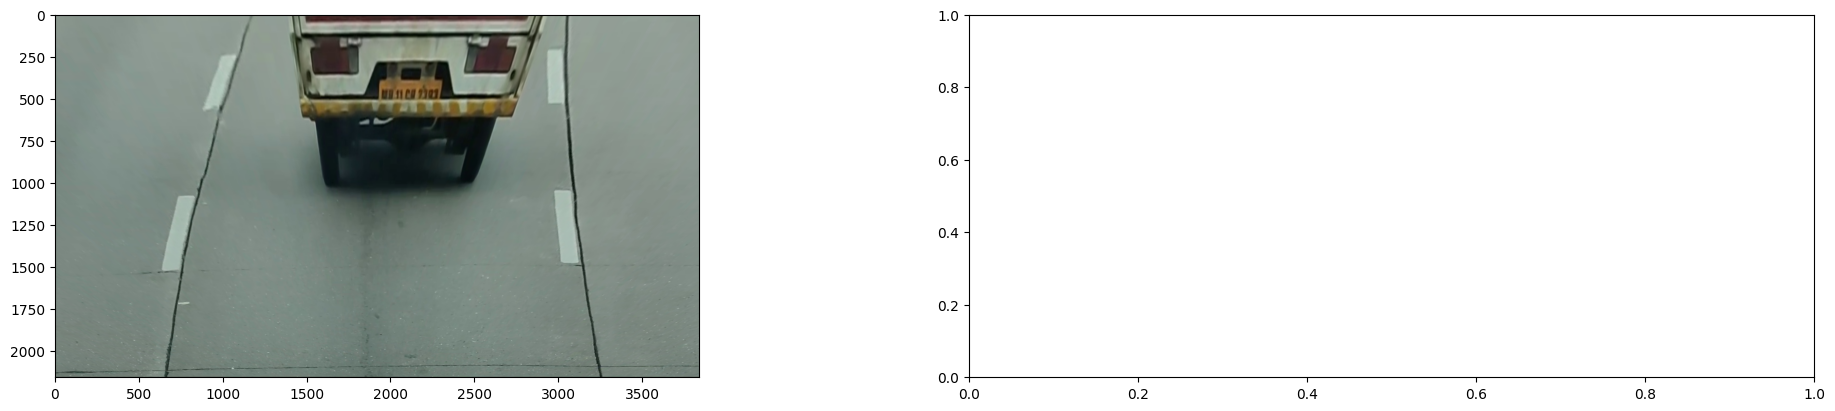

In [103]:
n=0
for frame in images:
    transformed = PerspectiveTransformation().forward(frame)
    thresholded = threshold(transformed)
    lane_area = lanelines.forward(thresholded)
    cv2.namedWindow("test", cv2.WINDOW_NORMAL)
    W = 1300
    H = 201
    widget = np.copy(lane_area[:H, :W])
    widget //= 2
    widget[0,:] = [0, 0, 255]
    widget[-1,:] = [0, 0, 255]
    widget[:,0] = [0, 0, 255]
    widget[:,-1] = [0, 0, 255]
    lane_area[:H, :W] = widget
        
    cv2.putText(
        lane_area,
        "Frame {:.2f}".format(n),
        org=(50, 110),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=2,
        color=(255, 255, 255),
        thickness=5)
    cv2.imshow('test', lane_area)
    cv2.waitKey(0)
    n+=10

In [ ]:
rouge frames = [30, 100, 110]